In [1]:
import jax
from jax import numpy as jnp

In [6]:
e2_esters = [
    {
        "name": "Estradiol benzoate",
        "log_p": 4.7,
        "t1/2": 3.5 * 24,  # 84 hr
        "acid_chain_length": 7,  # Benzoic acid (C7)
        "acid_log_p": 1.87  # Benzoic acid experimental logP
    },
    {
        "name": "Estradiol cypionate",
        "log_p": 6.9,
        "t1/2": 9 * 24,  # 216 hr
        "acid_chain_length": 9,  # Cypionic acid (C9)
        "acid_log_p": 2.04  # Cypionic acid predicted logP (no experimental available)
    },
    {
        "name": "Estradiol enanthate",
        "log_p": 6.7,
        "t1/2": 7 * 24,  # 168 hr
        "acid_chain_length": 7,  # Enanthic acid (C7)
        "acid_log_p": 2.42  # Heptanoic acid experimental logP
    }
]

t_esters = [
    {
        "name": "Testosterone propionate",
        "log_p": 3.65,
        "t1/2": 0.8 * 24,  # 19.2 hr
        "acid_chain_length": 3,  # Propionic acid (C3)
        "acid_log_p": 0.33  # Propionic acid experimental logP
    },
    {
        "name": "Testosterone enanthate",
        "log_p": 6.29,
        "t1/2": 4.8 * 24,  # 115.2 hr
        "acid_chain_length": 7,  # Enanthic acid (C7)
        "acid_log_p": 2.42  # Heptanoic acid experimental logP
    },
    {
        "name": "Testosterone cypionate",
        "log_p": 6.4,
        "t1/2": 8 * 24,  # 192 hr
        "acid_chain_length": 8,  # Cypionic acid (C8)
        "acid_log_p": 2.04  # Cypionic acid predicted logP (no experimental available)
    },
    {
        "name": "Testosterone undecanoate",
        "log_p": 9.1,
        "t1/2": 20.9 * 24,  # 501.6 hr
        "acid_chain_length": 11,  # Undecanoic acid (C11)
        "acid_log_p": 4.42  # Undecanoic acid experimental logP
    }
]


Fitted model: t1/2 = 1.995 * exp(0.663 * logP)


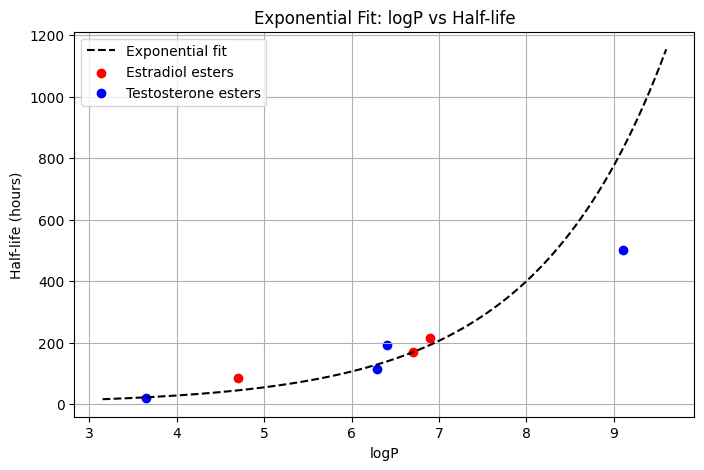

In [18]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import grad

# Original data
e_log_p = jnp.array([e["log_p"] for e in e2_esters])
e_t_half = jnp.array([e["t1/2"] for e in e2_esters])

t_log_p = jnp.array([e["log_p"] for e in t_esters])
t_t_half = jnp.array([e["t1/2"] for e in t_esters])

# Combine data
log_p = jnp.concatenate([e_log_p, t_log_p])
t_half = jnp.concatenate([e_t_half, t_t_half])

# Take natural log of half-life for linearization
log_t_half = jnp.log(t_half)

# Define linear regression for ln(t1/2) = ln(A) + B*log_p
def loss_fn(params):
    intercept, slope = params
    y_pred = intercept + slope * log_p
    return jnp.mean((log_t_half - y_pred) ** 2)

grad_fn = grad(loss_fn)
params = jnp.array([0.0, 0.0])
learning_rate = 0.01
num_steps = 500

for _ in range(num_steps):
    grads = grad_fn(params)
    params = params - learning_rate * grads

intercept, slope = params

# Model function (exponential)
def exp_model(x):
    return jnp.exp(intercept) * jnp.exp(slope * x)

print(f"Fitted model: t1/2 = {jnp.exp(intercept):.3f} * exp({slope:.3f} * logP)")

# Plot
plt.figure(figsize=(8,5))
x_vals = jnp.linspace(log_p.min() - 0.5, log_p.max() + 0.5, 300)
plt.plot(x_vals, exp_model(x_vals), 'k--', label='Exponential fit')
plt.scatter(e_log_p, e_t_half, color='red', label='Estradiol esters')
plt.scatter(t_log_p, t_t_half, color='blue', label='Testosterone esters')

plt.xlabel('logP')
plt.ylabel('Half-life (hours)')
plt.title('Exponential Fit: logP vs Half-life')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
poly(12)

Array(1034.6089, dtype=float32)

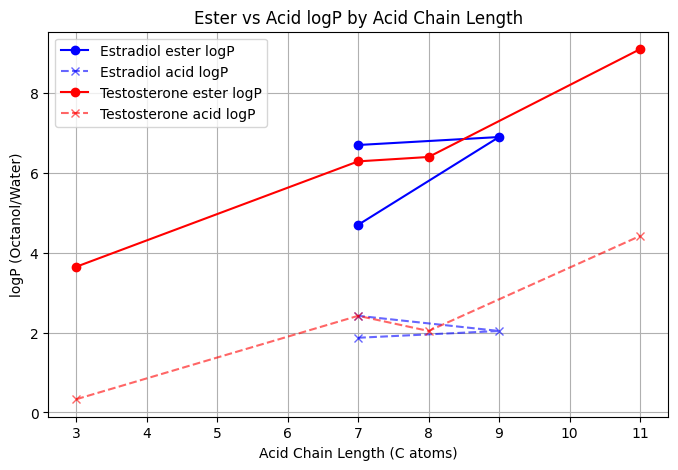

In [7]:

def extract_data(esters):
    chain_lengths = jnp.array([e["acid_chain_length"] for e in esters])
    ester_logp = jnp.array([e["log_p"] for e in esters])
    acid_logp = jnp.array([e["acid_log_p"] for e in esters])
    return chain_lengths, ester_logp, acid_logp

# Extract data arrays
e2_chain, e2_ester_logp, e2_acid_logp = extract_data(e2_esters)
t_chain, t_ester_logp, t_acid_logp = extract_data(t_esters)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(e2_chain, e2_ester_logp, 'o-', label='Estradiol ester logP', color='blue')
plt.plot(e2_chain, e2_acid_logp, 'x--', label='Estradiol acid logP', color='blue', alpha=0.6)

plt.plot(t_chain, t_ester_logp, 'o-', label='Testosterone ester logP', color='red')
plt.plot(t_chain, t_acid_logp, 'x--', label='Testosterone acid logP', color='red', alpha=0.6)

plt.xlabel('Acid Chain Length (C atoms)')
plt.ylabel('logP (Octanol/Water)')
plt.title('Ester vs Acid logP by Acid Chain Length')
plt.legend()
plt.grid(True)
plt.show()

Fitted model: ester_logP = 0.842 + 0.721 * acid_chain_length


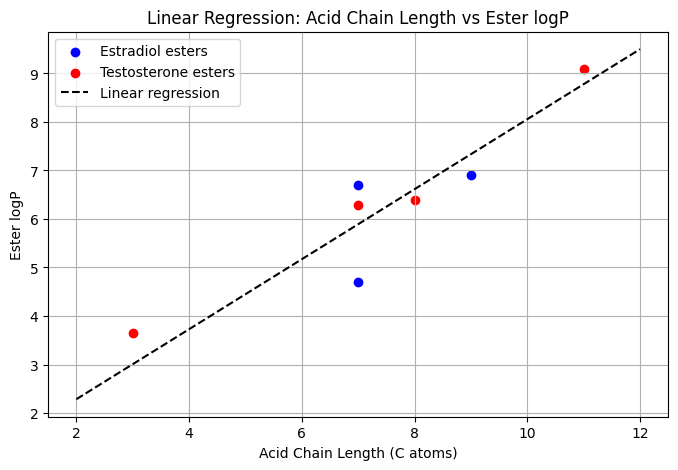

In [9]:

# Combine data
acid_chain = jnp.concatenate([e2_chain, t_chain])
ester_logp = jnp.concatenate([e2_ester_logp, t_ester_logp])

# Define loss function for linear regression
def loss_fn(params):
    intercept, slope = params
    y_pred = intercept + slope * acid_chain
    return jnp.mean((ester_logp - y_pred) ** 2)

# Gradient of loss function
grad_fn = grad(loss_fn)

# Initialize parameters
params = jnp.array([0.0, 0.0])

# Gradient descent hyperparameters
learning_rate = 0.01
num_steps = 500

# Gradient descent loop
for _ in range(num_steps):
    grads = grad_fn(params)
    params = params - learning_rate * grads

intercept, slope = params

# Define the regression model function
def predict(chain_length):
    return intercept + slope * chain_length

print(f"Fitted model: ester_logP = {intercept:.3f} + {slope:.3f} * acid_chain_length")

# Plot data points and regression line
plt.figure(figsize=(8, 5))
plt.scatter(e2_chain, e2_ester_logp, color='blue', label='Estradiol esters')
plt.scatter(t_chain, t_ester_logp, color='red', label='Testosterone esters')

# Create smooth line for regression
x_vals = jnp.linspace(acid_chain.min() - 1, acid_chain.max() + 1, 100)
y_vals = predict(x_vals)

plt.plot(x_vals, y_vals, 'k--', label='Linear regression')

plt.xlabel('Acid Chain Length (C atoms)')
plt.ylabel('Ester logP')
plt.title('Linear Regression: Acid Chain Length vs Ester logP')
plt.legend()
plt.grid(True)
plt.show()



In [10]:
# Estradiol Palmitate 

predict(16)

Array(12.384315, dtype=float32)

In [21]:
poly(12) / 24

Array(43.108704, dtype=float32)